# Regularization

**by Joseph Gonzalez (Spring 2020)**

**Note:** scikit-learn's `Pipeline` functionality is explored at length in this notebook. Instead, focus on the bigger picture, of how we are using regularization in practice.

## Regularization

In this notebook we explore the use of regularization techniques to address overfitting.  

## Imports

As with other notebooks we will use the same set of standard imports.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

## The Data

For this notebook, we will use the seaborn `mpg` dataset which describes the fuel mileage (measured in miles per gallon or mpg) of various cars along with characteristics of those cars.  Our goal will be to build a model that can predict the fuel mileage of a car based on the characteristics of that car.

In [46]:
from seaborn import load_dataset
data = load_dataset("mpg")
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


The first thing we will want to do with this data is construct a train/test split.

In [5]:
tr, te = train_test_split(data, test_size=0.25, random_state=83)

<br/><br/><br/>

---

## Building a Few Basic Models

The following code uses scikit-learn `Pipeline`s which are not in scope for the fall. Again, treat `Pipeline`s as a black-box that specify the features that our models use.

In [47]:
models = {}

In [48]:
quantitative_features = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"]

In [51]:
for i in range(len(quantitative_features)):
    # The features to include in the ith model
    features = quantitative_features[:(i+1)]
    # The name we are giving to the ith model
    name = ",".join([name[0] for name in features])
    # The pipeline for the ith model
    model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", features),
        ])),
        ("Imputation", SimpleImputer()),
        ("LinearModel", LinearRegression())
    ])
    # Fit the pipeline
    model.fit(tr, tr['mpg']);
    # Saving the ith model
    models[name] = model

We have defined and trained (fit) 5 models:

In [52]:
models.keys()

dict_keys(['c', 'c,d', 'c,d,h', 'c,d,h,w', 'c,d,h,w,a', 'c,d,h,w,a,m'])

<br/><br/><br/>


---

## `cross_val_score`

Before we proceed, we'll look at how to use `cross_val_score`, a method built-in to `sklearn.model_selection`, to give us the CV RMSE of our models.

In [53]:
from sklearn.model_selection import cross_val_score

The `cross_val_score` function takes a score function which it cross validates.  That score function must take three arguments, the model, X, and y.  We implement an Root Mean Squared Error (RMSE) score function:

In [54]:
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

We can then use `cross_val_score` to **estimate the test RMSE** for the model that only uses the number of cylinders `c`:

In [55]:
cross_val_score(models['c'], tr, tr['mpg'], scoring=rmse_score, cv=5)

array([5.34219804, 4.31960704, 4.17949277, 4.89156037, 5.65044712])

Taking the mean we get the average cross validation (CV) RMSE:

In [56]:
np.mean(cross_val_score(models['c'], tr, tr['mpg'], scoring=rmse_score, cv=5))

4.876661068256957

### Visualizing the Train/CV/Test RMSE

In the following helper function we plot the **Train** and **CV** RMSE.  **We also plot the test RMSE for educational purposes you should not do this! If you use the height of the test RMSE bar to make decisions in designing your model you have invalidated the test data sort of like looking at the exam when studying.**

In [57]:
def compare_models(models):
    # Compute the training error for each model
    training_rmse = [rmse_score(model, tr, tr['mpg']) for model in models.values()]
    # Compute the cross validation error for each model
    validation_rmse = [np.mean(cross_val_score(model, tr, tr['mpg'], scoring=rmse_score, cv=5)) 
                       for model in models.values()]
    # Compute the test error for each model (don't do this!)
    test_rmse = [rmse_score(model, te, te['mpg']) for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        go.Bar(x = names, y = validation_rmse, name="CV RMSE"),
        go.Bar(x = names, y = test_rmse, name="Test RMSE", opacity=.3)])
    fig.update_yaxes(title="RMSE")
    return fig

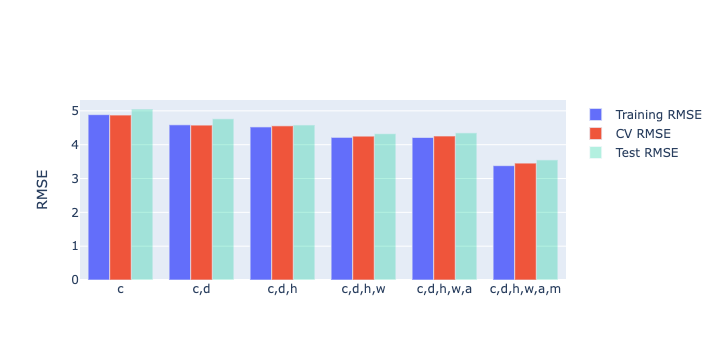

In [58]:
compare_models(models)

Notice that as we added features the training and cross validation error generally decreased.  Also notice that the cross validation error and the test error are generally higher than the training error. 

<br/><br/><br/>

---

## Adding the Text Features

### Adding the Origin

The origin is a categorical feature which takes on only a few values:

In [59]:
tr['origin'].value_counts()

usa       188
japan      56
europe     54
Name: origin, dtype: int64

This can be extracted using a `OneHotEncoder` in the `SelectColumns` stage of the pipeline. Notice that the `["origin"]` is in brackets, this caused me some confusion when preparing lecture.  The `OneHotEncoder` wants its input in column form rather than list form. 

In [61]:
from sklearn.preprocessing import OneHotEncoder

In [62]:
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"])
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

In [63]:
model.fit(tr, tr['mpg'])
name = ",".join([name[0] for name in quantitative_features]) + ",o"
models[name] = model

### Adding the Vehicle Name

In the previous lecture we added the vehicle name using the `CountVectorizer` which implements a bag-of-words encoding. 

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [65]:
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

In [67]:
model.fit(tr, tr['mpg'])
name = ",".join([name[0] for name in quantitative_features]) + ",o,n"
models[name] = model

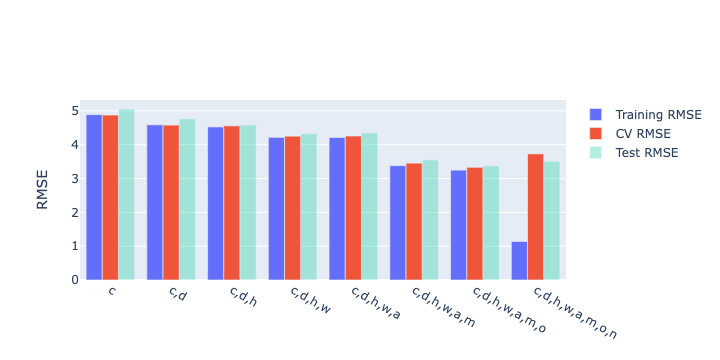

In [68]:
compare_models(models)

Notice that adding the origin of the vehicle resulted in a small decrease in training error and validation error but adding the name resulted in a large decrease in training error and moderate increase in validation error.  The introduction of vehicle name feature resulted in overfitting.  To see why this might have happened let's look at the number of features in each model.

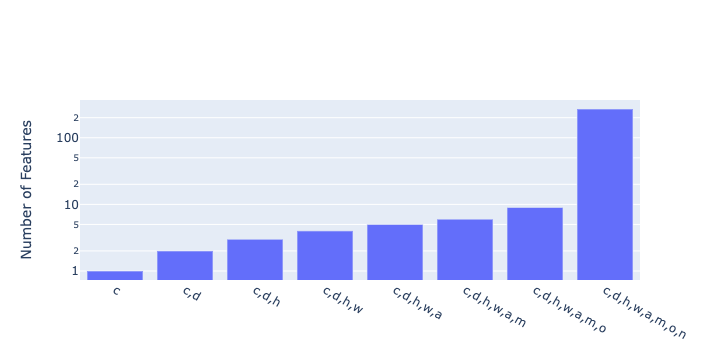

In [69]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = list(models.keys()), 
    y = [len(models[m]["LinearModel"].coef_) for m in models]
))
fig.update_yaxes(title="Number of Features",type="log")

Notice that the above plot is in log scale on the y axis!  The addition of the model name resulted in a large jump in features.  Perhaps some of these new features are useful and some are not.  What we really want now is a mechanism to select which of these features to keep and which to ignore or down-weight.  This can be done by using regularization. 

## Regularization

Broadly speaking, regularization refers to methods used to control over-fitting.  However, in this class we will focus on parametric regularization techniques.

The simplest way to think about regularization is in the context of our original loss minimization problem. Recall we defined the loss function which determines what is the best parameter value $\hat{\theta}$ for our model. 

$$
\hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(Y_i, f_\theta(X_i)\right)
$$

The loss captures how well our model fits the data.  What we need is a way to a way to penalize models that over-fit to the data.  We can do this by adding an extra term to our loss minimization problem:


$$
\hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(Y_i, f_\theta(X_i)\right) + \alpha \textbf{Reg}(f_\theta, X, Y)
$$

The **Reg** function measures how much our model overfits and $\alpha$ parameter (really hyper-parameter) allows us balance fitting our data and overfitting. The remaining challenge is how to define this **Reg** function and determine the value of our additional $\alpha$ parameter.  


### The Regularization Hyper-parameter
The $\alpha$ parameter is our regularization **hyper-parameter**.  It is a hyper-parameter because it is not a model parameter but a choice of how we want to balance fitting the data and "over-fitting".  The goal is to find a value of this hyper-parameter to maximize our accuracy on the **test data**. However, **we can't use the test data to make modeling decisions** so we turn to cross validation.  The standard way to find the best $\alpha$ is to try a bunch of values (perhaps using binary search) and take the one with the lowest cross validation error. 

You may have noticed that in the video lecture we use $\lambda$ instead of $\alpha$.  This is because many textbooks use $\lambda$ and sklearn uses $\alpha$.

### The Regularization Function 

In our cartoon formulation of the regularized loss, the regularization function **Reg** is supposed to "measure" how much our model "overfits".  It depends on the model parameters and also can depend on the data.  An obvious choice for this function could be the gap between training and cross validation error but that is difficult to optimize and somewhat circular since both training and validation error depend on solving the regularized loss minimization problem. 

We have already seen that the more features we have the more likely we are to overfit to our data.  For our linear model, if we set a parameter to 0 then that is the same as not having that feature.  Therefore, one possible regularization function could be to count the non-zero parameters in our model.

$$
\textbf{Reg}(\theta) = \sum_{k=1}^d (\theta_i \neq 0)
$$

To minimize this function would be to ignore all the features and that would certainly not overfit.  This is actually, the "feature selection" regularization objective.  Unfortunately, optimizing this objective is very hard (NP-Hard).  

However, there are some good approximations we can use:

$$
\textbf{Reg}^\text{ridge}(\theta) = \sum_{k=1}^d \theta_i^2
$$

and

$$
\textbf{Reg}^\text{lasso}(\theta) = \sum_{k=1}^d \left|\theta_i \right|
$$

Each of these regularization functions (and their combination) give rise to different regression techniques.



### Ridge Regression

Ridge regression combines the ridge (L2, Squared) regularization function with the least squares loss.  


$$
\hat{\theta}_\alpha = \arg \min_\theta \left(\frac{1}{n} \sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \right) + \alpha \sum_{k=1}^d \theta_k^2
$$



Ridge regression, like ordinary least squares regression, also has a closed form solution for the optimal $\hat{\theta}_\alpha$

$$
\hat{\theta}_\alpha = \left(X^T X + n \alpha \mathbf{I}\right)^{-1} X^T Y
$$

where $\mathbf{I}$ is the identity matrix, $n$ is the number of data points, and $\alpha$ is the regularization hyper-parameter.

Notice that even if $X^T X$ is not full rank, the addition of $n \alpha \mathbf{I}$ (which is full rank) makes $\left(X^T X + n \alpha \mathbf{I}\right)$ invertible.  Thus, ridge regression addresses our earlier issue of having an underdetermined system and partially improves the numerical stability of the solution. 

### Lasso Regression

Lasso regression combines the absolute (L1) regularization function with the least squares loss.  

$$
\hat{\theta}_\alpha = \arg \min_\theta \left(\frac{1}{n} \sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \right) + \alpha \sum_{k=1}^d |\theta_k|
$$

Lasso is actually an acronym (and a cool name) which stands for Least Absolute Shrinkage and Selection Operator.  It is an absolute operator because it is the absolute value.  It is a shrinkage operator because it favors smaller parameter values.  It is a selection operator because it has the peculiar property of pushing parameter values all the way to zero thereby selecting the remaining features.  It is this last property that makes Lasso regression so useful. By using Lasso regression and setting sufficiently large value of $\alpha$ you can eliminate features that are not informative. 

Unfortunately, there is no closed form solution for Lasso regression and so iterative optimization algorithms like gradient descent are typically used. 

### Normalizing the Features

When applying Ridge or Lasso regression it is important that you normalize your features.  Why (think about it for a second)?  

The issue is that if you have very large and very small features then the relative magnitudes of the coefficients may differ substantially.  Think of the coefficients as unit translations from units of features (e.g., cubic centimeters, and horse power) to units of the thing you are trying to predict (e.g., miles per gallon).  The regularization function treats all these unit translation coefficients equally but some may *need* to be much larger than others.  Therefore, by *standardizing the features* we can address this variation.   You can standardize a feature by computing:

$$
z = \frac{x - \textbf{Mean}(x)}{\textbf{StdDev}(x)}
$$

## Ridge Regression in SK Learn

Both Ridge Regression and Lasso are built-in functions in SKLearn.  Let's start by importing the `Ridge` Regression class which behaves identically to the `LinearRegression` class we used earlier:

In [70]:
from sklearn.linear_model import Ridge

Take a look at the documentation.  Notice the regularized loss function. 

In [71]:
Ridge?

Init signature:
Ridge(
    alpha=1.0,
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    max_iter=None,
    tol=0.001,
    solver='auto',
    random_state=None,
)
Docstring:     
Linear least squares with l2 regularization.

Minimizes the objective function::

||y - Xw||^2_2 + alpha * ||w||^2_2

This model solves a regression model where the loss function is
the linear least squares function and regularization is given by
the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
This estimator has built-in support for multi-variate regression
(i.e., when y is a 2d-array of shape (n_samples, n_targets)).

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alpha : {float, ndarray of shape (n_targets,)}, default=1.0
    Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    A

We can plug the Ridge Regression Model in place of our the LinearRegression Model in our earlier pipeline.

In [27]:
ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", Ridge(alpha=0.5))
])

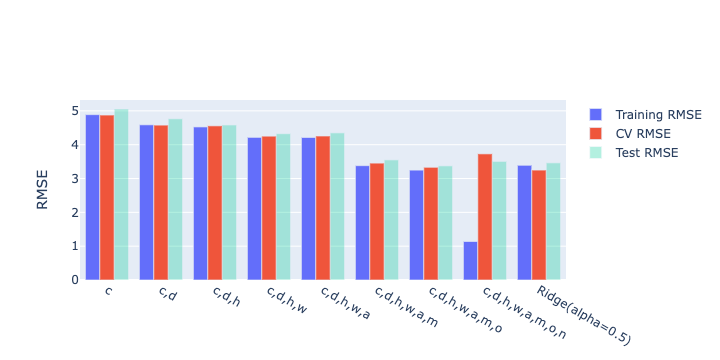

In [28]:
ridge_model.fit(tr, tr['mpg'])
models["Ridge(alpha=0.5)"] = ridge_model
compare_models(models)

We should also standardize our features:

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
#     ("Standarize", StandardScaler(with_mean=False)),
    ("LinearModel", Ridge(alpha=0.5))
])

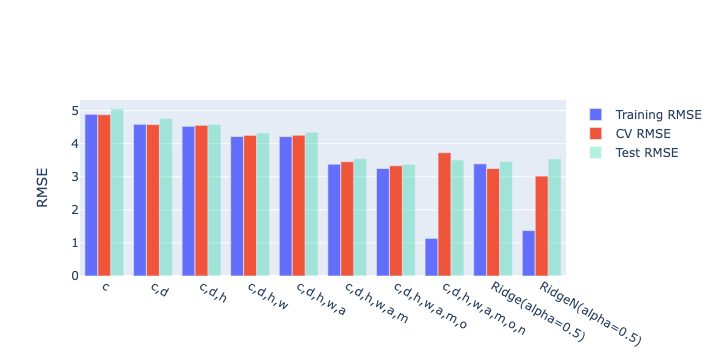

In [31]:
ridge_model.fit(tr, tr['mpg'])
models["RidgeN(alpha=0.5)"] = ridge_model
compare_models(models)

Notice that as we introduce regularization we are reducing the cross validation error and also increasing the training error.

What about different $\alpha$ hyper-parameter values?

In [32]:
ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", Ridge(alpha=10))
])

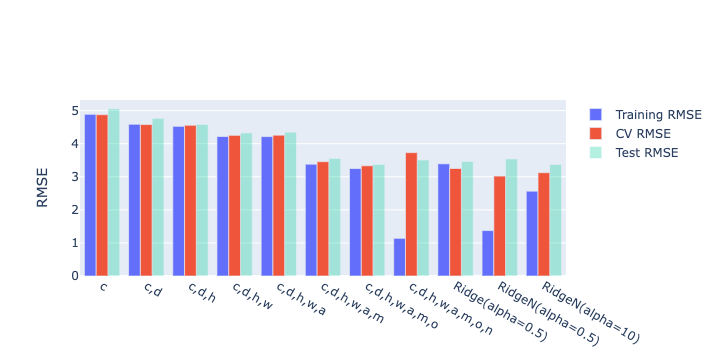

In [33]:
ridge_model.fit(tr, tr['mpg'])
models["RidgeN(alpha=10)"] = ridge_model
compare_models(models)

That is too much regularization.  Let's use cross validation to pick the best value.

### Cross Validation to Tune Regularization Parameter

The following uses cross validation to tune the regularization parameter.

In [34]:
ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", Ridge(alpha=10))
])

alphas = np.linspace(0.5, 20, 30)
cv_values = []
train_values = []
test_values = []
for alpha in alphas:
    ridge_model.set_params(LinearModel__alpha=alpha)
    cv_values.append(np.mean(cross_val_score(ridge_model, tr, tr['mpg'], scoring=rmse_score, cv=5)))
    ridge_model.fit(tr, tr['mpg'])
    train_values.append(rmse_score(ridge_model, tr, tr['mpg']))
    test_values.append(rmse_score(ridge_model, te, te['mpg']))

We can plot the cross validation error against the different $\alpha$ values and pick the $\alpha$ with the smallest cross validation error. 

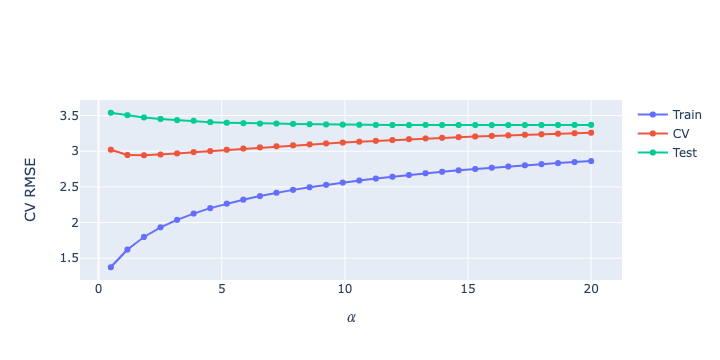

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = alphas, y = train_values, mode="lines+markers", name="Train"))
fig.add_trace(go.Scatter(x = alphas, y = cv_values, mode="lines+markers", name="CV"))
fig.add_trace(go.Scatter(x = alphas, y = test_values, mode="lines+markers", name="Test"))
fig.update_layout(xaxis_title=r"$\alpha$", yaxis_title="CV RMSE")

Adding the best model:

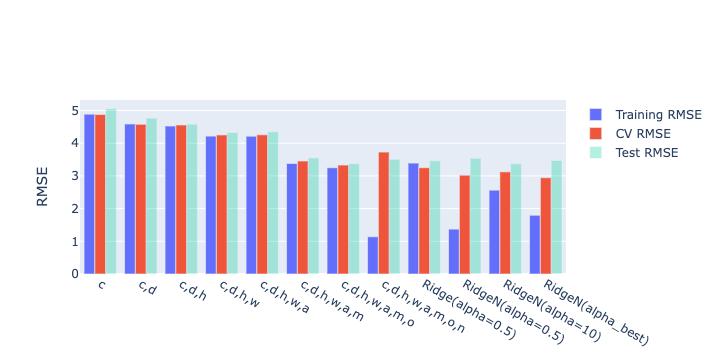

In [36]:
best_alpha = alphas[np.argmin(cv_values)]
ridge_model.set_params(LinearModel__alpha=best_alpha)
ridge_model.fit(tr, tr['mpg'])
models["RidgeN(alpha_best)"] = ridge_model
compare_models(models)

We didn't have to do all of that work. SKLearn has a Ridge Regression class with built-in cross validation

In [37]:
from sklearn.linear_model import RidgeCV

In [38]:
alphas = np.linspace(0.5, 3, 30)

ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", RidgeCV(alphas=alphas))
])

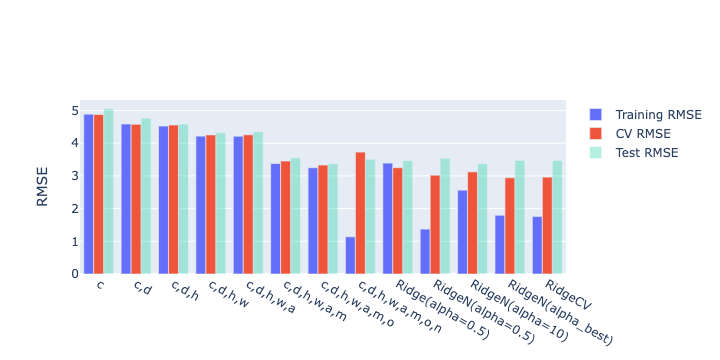

In [39]:
ridge_model.fit(tr, tr['mpg'])
models["RidgeCV"] = ridge_model
compare_models(models)

## Lasso in SKLearn 

Similarly we can swap Ridge Regression for Lasso by simply importing the Lasso object from `sklearn.linear_model`.

In [40]:
from sklearn.linear_model import Lasso, LassoCV

In [41]:
lasso_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["origin"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LassoCV(cv=3))
])

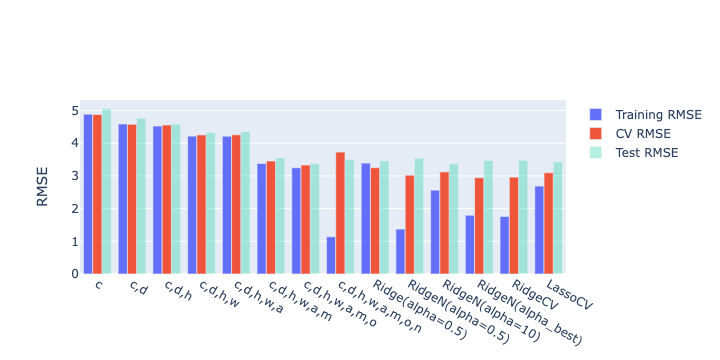

In [42]:
lasso_model.fit(tr, tr['mpg'])
models["LassoCV"] = lasso_model
compare_models(models)

We can examine the distribution of model coefficients to see that Lasso is selecting only a few of the features to use in it's predictions:

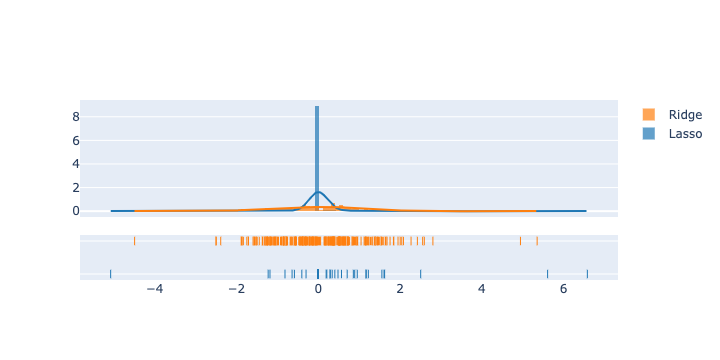

In [43]:
ff.create_distplot([
    models['LassoCV']["LinearModel"].coef_, 
    models['RidgeCV']["LinearModel"].coef_],
    ["Lasso", "Ridge"], bin_size=0.1)

Here we get the names of all the features in the model.

In [44]:
ct = models['LassoCV']['SelectColumns']
feature_names = (
    quantitative_features +
    list(ct.named_transformers_['origin_encoder'].get_feature_names())+
    list(ct.named_transformers_['text'].get_feature_names())
)
feature_names = np.array(feature_names)
print(feature_names)

['cylinders' 'displacement' 'horsepower' 'weight' 'acceleration'
 'model_year' 'x0_europe' 'x0_japan' 'x0_usa' '10' '100' '100ls' '111'
 '1131' '12' '1200' '1200d' '124' '128' '12tl' '1300' '144ea' '1500' '18i'
 '1900' '200' '2000' '2002' '200sx' '210' '225' '2300' '240d' '244dl'
 '245' '280s' '300d' '304' '310' '320i' '340' '350' '4000' '411' '4w'
 '500' '5000' '504' '505s' '510' '610' '626' '710' '810' '88' '99gle'
 '99le' 'accord' 'air' 'ambassador' 'amc' 'aries' 'aspen' 'audi' 'auto'
 'beetle' 'bel' 'benz' 'bmw' 'brougham' 'buick' 'c10' 'cadillac' 'camaro'
 'capri' 'caprice' 'carina' 'carlo' 'catalina' 'cavalier' 'celica'
 'century' 'challenger' 'champ' 'chevelle' 'chevette' 'chevroelt'
 'chevrolet' 'chevy' 'chrysler' 'ciera' 'citation' 'civic' 'classic'
 'cobra' 'colt' 'concord' 'concours' 'corolla' 'corona' 'coronet' 'cougar'
 'country' 'coupe' 'cressida' 'cuda' 'custom' 'cutlass' 'cvcc' 'd100'
 'd200' 'dart' 'dasher' 'datsun' 'delta' 'deluxe' 'diesel' 'diplomat' 'dl'
 'dodge' 'd

Finally, we select the features that had non-zero coefficients (parameters).  Not surprisingly, many of these features are likely good predictors of the fuel economy of a car.

In [45]:
kept = ~np.isclose(models['LassoCV']["LinearModel"].coef_, 0)
feature_names[kept]

array(['cylinders', 'displacement', 'weight', 'acceleration',
       'model_year', 'x0_usa', '1200', '1500', '210', 'amc', 'civic',
       'colt', 'corolla', 'custom', 'datsun', 'diesel', 'ford',
       'hatchback', 'honda', 'horizon', 'ii', 'maxda', 'plymouth',
       'pontiac', 'rabbit', 'renault', 'rx', 'rx3', 'sw', 'tercel', 'vw'],
      dtype='<U12')